# DSCI 100 Group Project Proposal

team: Rachel Liang, Ziyan He, Yuchen Zhang, Zohane Bal

In [45]:
### Run this cell before continuing. 
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Introduction    

The dataset we are working on is downloaded from the UCI Machine Learning Repository. Although the dataset contains four databases about the heart disease diagnosis from 4 different locations, we only picked the database collected from the Cleveland Clinic Foundation since it is the only data base that has full 14 attributes recored for each heart disease diagnosis. The total instances in this database is 303.

### Load Data and Wrangle Data
This dataset does not need to be cleaned since it does not have any missing data or missing attributes. <br>
We added column names to the dataset and selected columns we needed for analysis. Also as we are treating some attributes's numeric values as categorical variables, we used as.factor() for conversion.

In [46]:
set.seed(1234)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num"))
heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### 14 Attributes Description
* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing

### Observation from the Correlation Plot
Through the correlation plot we found five predictors with relatively large absolute correlation value, which are cp, thalach, exang, oldpeak, and slope.<br> We excluded the two factors which are age and sex that we thought would have a great influence on the target variable, num. In the end, having the above five predictors chosen to predict the presence of heart disease.

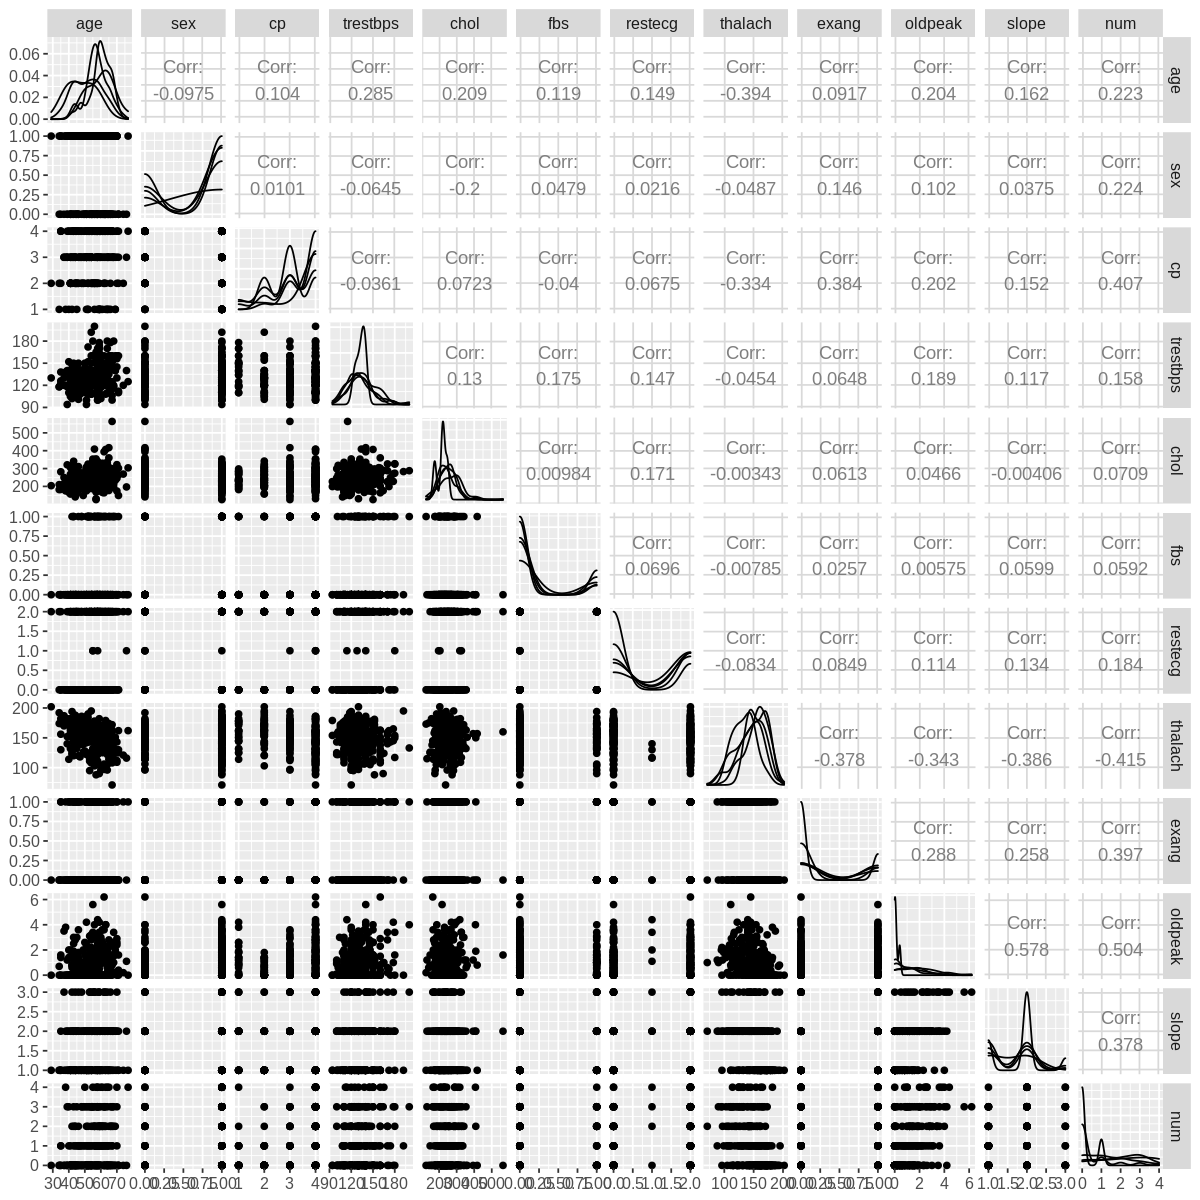

In [52]:
correlation_plot <- heart_disease_data %>% 
                select(-ca, -thal) %>% 
                ggpairs(heart_disease_data[1:12]) +
                theme(text = element_text(size = 12))


correlation_plot

### Some visualizations of the dataset
We try to visualize which type of chest pain occurs most often in different levels of heart disease(0 meaning zero probability of having heart diseanse, and 4 meaning the most probability of having a heart disease).<br>
We observed that individuals having type 4 chest pain which is asymptomatic chest pain, have the most probobility(4) of having heart disease.

`summarise()` regrouping output by 'num' (override with `.groups` argument)



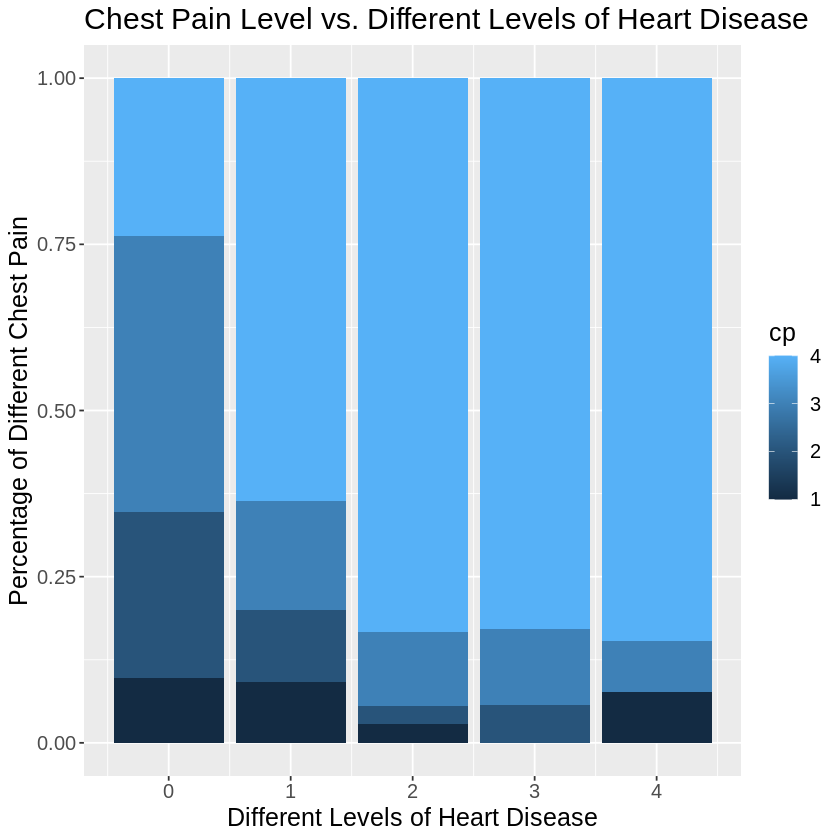

In [63]:
options(repr.plot.width = 7, repr.plot.height = 7)

cp_vs_num <- heart_disease_data %>% 
            select(num, cp) %>% 
            group_by(num, cp) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = cp)) +
            labs(x="Different Levels of Heart Disease", y= "Percentage of Different Chest Pain")+
            geom_bar(stat = "identity",position = "fill") +
            ggtitle("Chest Pain Level vs. Different Levels of Heart Disease")+
            theme(text = element_text(size = 15))
cp_vs_num

`summarise()` regrouping output by 'num' (override with `.groups` argument)



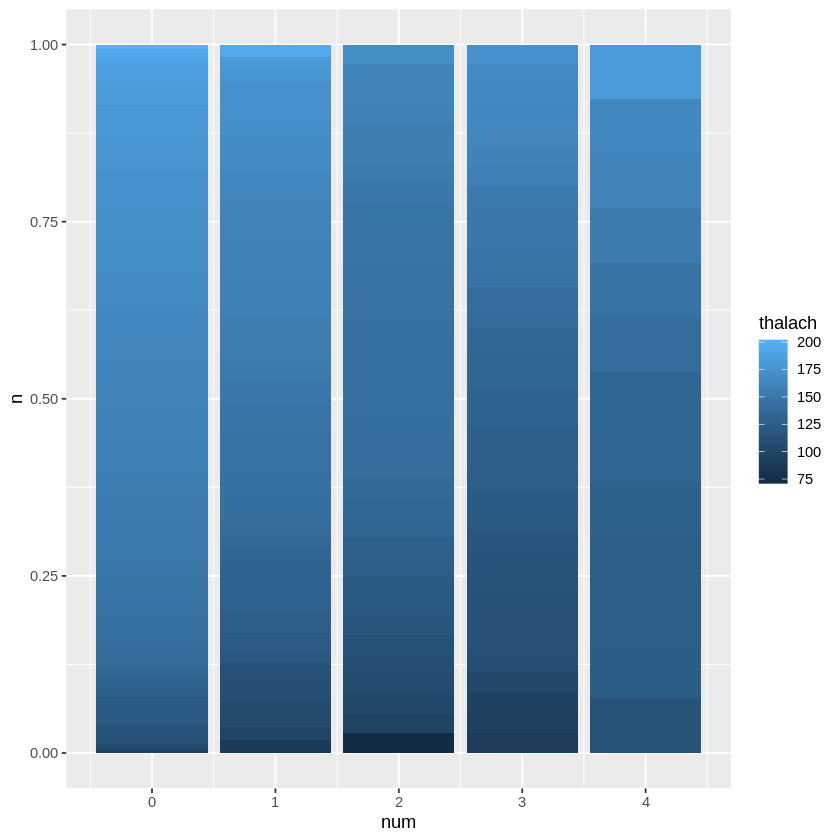

In [66]:
thalach_vs_num <- heart_disease_data %>% 
            select(num, thalach) %>% 
            group_by(num, thalach) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = thalach)) +
            geom_bar(stat = "identity",position = "fill")
thalach_vs_num

In [69]:
# set.seed(1234)
# heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
#                                                                "restecg", "thalach", "exang", "oldpeak", "slope",
#                                                                "ca", "thal", "num")) %>% 
#                         mutate(num = as.factor(num)) %>% 
# #                         mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg), 
# #                             exang = as.factor(exang), slope = as.factor(slope), sex = as.factor(sex)) %>% 
#                         select(age, sex, cp, thalach, exang, slope, num, oldpeak) 
# heart_disease_data

### Check for balancing
We found the count and percentage of the probability of getting heart disease diagnosis observations in our data set. We observed that our heart disease data set has this “num” (diagnosis of heart disease) imbalance, that is, we have the class, the zero chance of getting heart disease label, more common than the others. We therefore resolve this issue by grouping all the non-zero probability levels of having heart diseases into one group. Thus, we will now have num having two classes.

In [68]:
num_obs <- nrow(heart_disease_data)
        heart_disease_data %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


drawing multiple histograms and the x-axis is the num (possibility of getting heart disease : 0, 1, 2, 3) and the y-axis is the count. color the bar using position "filled" with each column (such as cp, fbs according to the larger correlation in the ggpair). if this variable has a high correlation related to getting heart disease, the proportion of color will be filled more in the larger x-axis, and otherwise. Also use medical research to add ontop of the correlation because correlation does not mean causation.

In [13]:
set.seed(1234)
heart_disease_data_2 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
#                         mutate(num = as.factor(num)) %>% 
#                         mutate(cp = as.numeric(as.factor(cp)), fbs = as.factor(fbs), restecg = as.factor(restecg), 
#                             exang = as.numeric(as.factor(exang)), slope = as.numeric(as.factor(slope)), 
#                                sex = as.numeric(as.factor(sex))) %>% 
                        select(cp, thalach, exang, slope, oldpeak, num) %>% 
                        mutate(num = as.factor(num))
heart_disease_data_2

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,2
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,3
2,174,0,2,0.0,1
3,173,0,1,0.0,0


In [14]:
heart_disease_data_3 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    select(cp, thalach, exang, slope, oldpeak, num) %>% 
                    mutate(num = as.factor(num))
                    
heart_disease_data_3                

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


### Check for balancing new

In [15]:
num_obs_new <- nrow(heart_disease_data_3)
        heart_disease_data_3 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_new * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


### Split Into Training and Testing Dataset
Based on the number of instances in this dataset, we decided that setting 75% of the data in the dataset as training data and the remaining 25% as testing data will make a good balance for training the classifier and evaluating the classifier's accuracy.

In [16]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data_2, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data_2, 10)

cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,2
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,163,1,1,0.6,0
4,147,0,2,1.4,2
4,155,1,3,3.1,1


### Summary

In [17]:
summary(heart_disease_train)

       cp           thalach          exang           slope         oldpeak     
 Min.   :1.000   Min.   : 71.0   Min.   :0.000   Min.   :1.00   Min.   :0.000  
 1st Qu.:3.000   1st Qu.:132.0   1st Qu.:0.000   1st Qu.:1.00   1st Qu.:0.000  
 Median :4.000   Median :152.0   Median :0.000   Median :2.00   Median :0.800  
 Mean   :3.227   Mean   :148.6   Mean   :0.345   Mean   :1.62   Mean   :1.049  
 3rd Qu.:4.000   3rd Qu.:165.0   3rd Qu.:1.000   3rd Qu.:2.00   3rd Qu.:1.600  
 Max.   :4.000   Max.   :202.0   Max.   :1.000   Max.   :3.00   Max.   :6.200  
 num    
 0:123  
 1: 43  
 2: 27  
 3: 27  
 4:  9  
        

### Visualization


The boxplot below shows the distribution of age for each different probability level of having a heart disease.

In [18]:
# age_vs_heart_disease <- heart_disease_train %>% 
#                     ggplot(aes(x = num, y = age)) +
#                     geom_boxplot(aes(group = num)) +
#                     labs(x = "Probability of having heart disease (from 0 to 4)", y = "Patient Age") +
#                     ggtitle("Age vs. Probability of having heart disease (from 0 to 4)") +
#                     theme(text = element_text(size = 20))
                    
# age_vs_heart_disease

The graph2 below shows the distribution of different chest pain types for different probability levels of having heart disease.<br>
Chest pain type 1-4 means:
* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
<br>


`summarise()` regrouping output by 'num' (override with `.groups` argument)



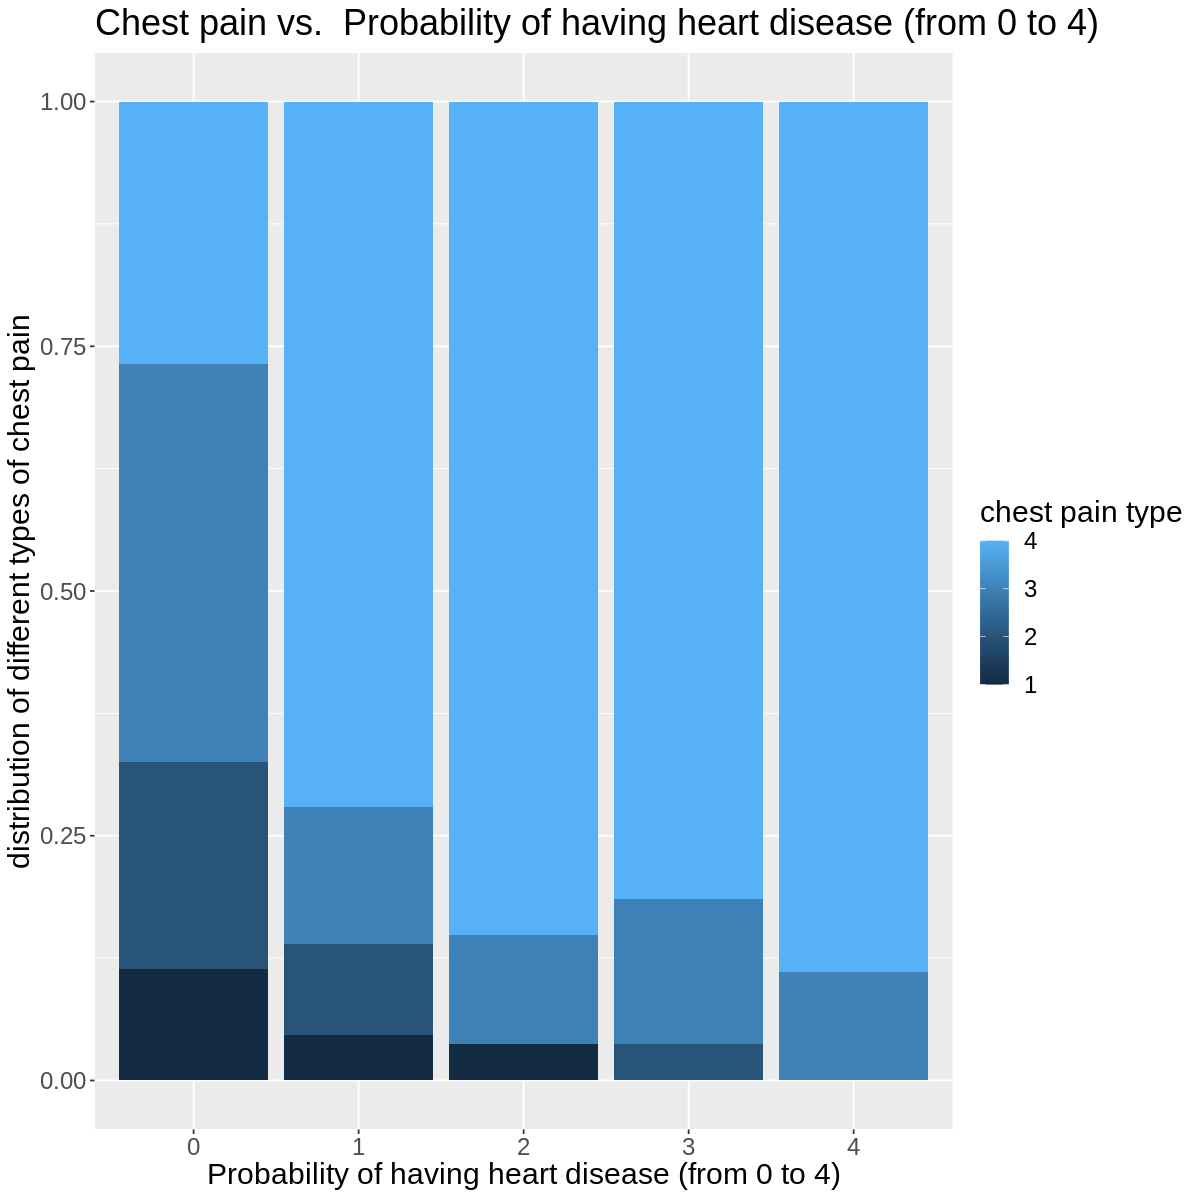

In [19]:
options(repr.plot.width = 10, repr.plot.height = 10) 

sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity",position = "fill") +
                        labs(x =  "Probability of having heart disease (from 0 to 4)", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("Chest pain vs.  Probability of having heart disease (from 0 to 4)") +
                        theme(text = element_text(size = 18))
sex_vs_heart_disease

### Method

In order to make the prediction, there are three steps to do:
1. Create a k-nn model specification and a recipe for the fit method.
2. Train the model with the training dataset to build the classifier.
3. Use the classifier to predict the labels in the test sets.       

#### 6 Predictors chosen:
* age, sex, chest pain types (cp), thalach, exang, oldpeak, the slope of the peak exercise ST segment(slope)




### Expected Outcomes and Significance    

1. What do you expect to find?   

    Our training dataset will allow us to predict the probability of an individual contracting heart disease given patient's . 
    Additionally, we hope to discover which factors are most associated with a person's risk of developing a heart disease.  

2. What impact could such findings have?    

    With this finding, doctors would be able to analyze patients’ records in a more informative manner. It will be easier to make a swift decision to conduct further diagnostic cardiology on the patient if a certain index is abnormal as indicated in the report later, and this will significantly reduce the chance of misdiagnosis and provide more time for patient diagnosis and treatment.  

3. What future questions could this lead to?   

    As this dataset only has 303 instances which is not sufficient for making accurate predictions, we could increase the accuracy of prediction by including more instances . Furthermore, since this data set only contains patients’ data in Cleveland, it would also be interesting to observe if the key factors leading to heart disease differ between different locations if we have a heart disease data set from a collection of locations. 


### Create models

In [20]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Create Recipe--MISSING UPSAMPLE

In [21]:
heart_recipe <- recipe(num ~ ., data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

# MISSING STEP_UPSAMPLE
# bake <- bake(heart_recipe,heart_disease_train)



heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit <- workflow() %>% 
            add_recipe(heart_recipe) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)



! Fold1: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4720655,5,0.02087265,Model01
2,accuracy,multiclass,0.4720655,5,0.02087265,Model02
3,accuracy,multiclass,0.5291044,5,0.02433927,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.6084535,5,0.02431864,Model48
49,accuracy,multiclass,0.6084535,5,0.02431864,Model49
50,accuracy,multiclass,0.6173423,5,0.02881612,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
50,accuracy,multiclass,0.6173423,5,0.02881612,Model50


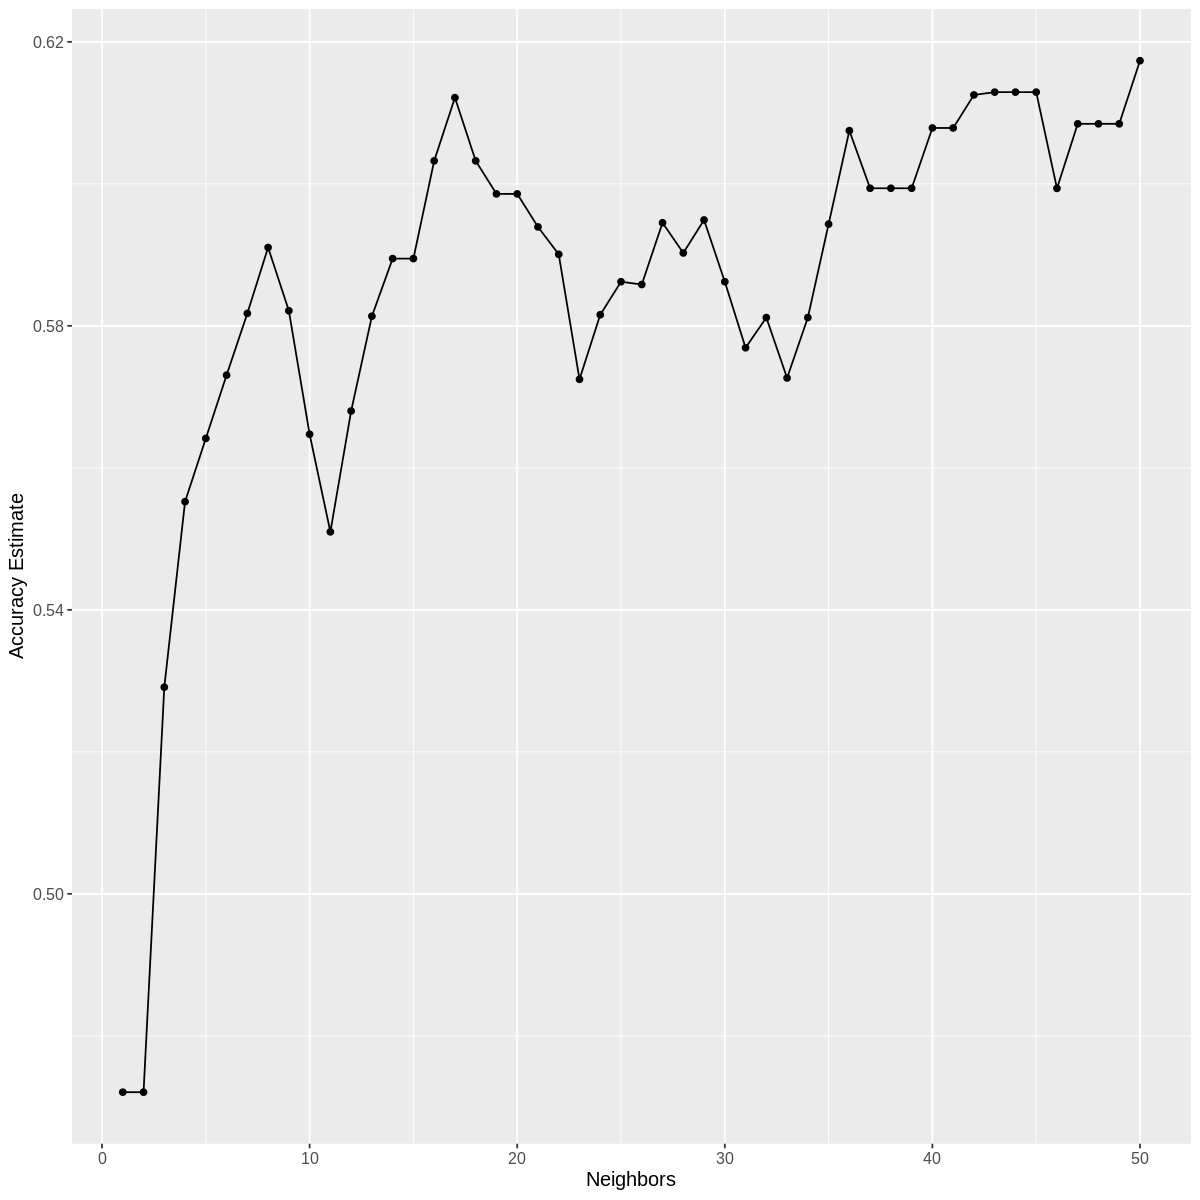

In [22]:
# set metrics

heart_disease_metrics <- knn_fit %>% 
                        collect_metrics()

accuracies <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") 
accuracies
    
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

accuracies_final <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final


In [23]:
# knn_tune

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_2 <- workflow() %>% 
  add_recipe(heart_recipe) %>% 
  add_model(knn_spec_2) %>% 
  fit(data = heart_disease_train)



In [24]:
# make predictions

heart_prediction <- predict(knn_fit_2, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics <- heart_prediction %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat <- heart_prediction %>% 
                 conf_mat(truth = num, estimate = .pred_class)

# mnist_metrics <- mnist_predictions %>%
#         metrics(truth = y, estimate = .pred_class) %>% 
#         filter(.metric == "accuracy")
# mnist_metrics
# mnist_conf_mat <- mnist_predictions %>% 
#                 conf_mat(truth = y, estimate = .pred_class)
heart_metrics
mnist_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6081081


          Truth
Prediction  0  1  2  3  4
         0 39  9  5  4  2
         1  1  3  1  1  0
         2  1  0  2  2  2
         3  0  0  1  1  0
         4  0  0  0  0  0

## optimizing our classifier


In [29]:
heart_recipe_new <- recipe(num ~ sex + cp + thalach + exang + slope, data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)


# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_new <- workflow() %>% 
            add_recipe(heart_recipe_new) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)



heart_disease_metrics_new <- knn_fit_new %>% 
                        collect_metrics()

accuracies_new <- heart_disease_metrics_new %>% 
        filter(.metric == "accuracy") 
accuracies_new
    
accuracy_vs_k_new <- ggplot(accuracies_new, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_new

accuracies_final_new <- heart_disease_metrics_new %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)

accuracies_final_new




ERROR: Error in eval(predvars, data, env): object 'sex' not found


In [32]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_new <- workflow() %>% 
  add_recipe(heart_recipe_new) %>% 
  add_model(knn_spec_2) %>% 
  fit(data = heart_disease_train)

heart_prediction_new <- predict(knn_fit_new, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics_new <- heart_prediction_new %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_new <- heart_prediction_new %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics_new
mnist_conf_mat_new

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6081081


          Truth
Prediction  0  1  2  3  4
         0 39  9  5  4  2
         1  1  3  1  1  0
         2  1  0  2  2  2
         3  0  0  1  1  0
         4  0  0  0  0  0

### Questions to ask: 
- upsample --> change the predicted variable to binary categorical. 
- final visualization
- optimizing our number of k neighbours
- clean up R error
- is our classifier trained: validate with test data
- 
- do we need to compare our result with the initial hypothesis using graphs
- potential risks -- TODO


using five predictors: with high correlation.
binary categorical -- 0 and 1
final visulizatino with bar chart(quantitative and categorical), boxplot(quantitative): 

## Mutating Num to binary categorical

In [33]:
heart_disease_data_3 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>%  
                    select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_3    

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


## Check for balancing

In [34]:
num_obs_new <- nrow(heart_disease_data_3)
        heart_disease_data_3 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_new * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


## Spliting and training data

In [35]:
set.seed(1234)
heart_disease_split_mut <- initial_split(heart_disease_data_3, prop = 0.75, strata = num)
heart_disease_train_mut <- training(heart_disease_split_mut)
heart_disease_test_mut <- testing(heart_disease_split_mut)

head(heart_disease_data_3, 10)

cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,163,1,1,0.6,0
4,147,0,2,1.4,1
4,155,1,3,3.1,1


## Create model

In [36]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [37]:
heart_recipe_mut <- recipe(num ~ ., data = heart_disease_train_mut)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut <- vfold_cv(heart_disease_train_mut, v = 5, strata = num)


In [38]:
k_lots_mut <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_mut <- workflow() %>% 
            add_recipe(heart_recipe_mut) %>% 
            add_model(knn_spec_mut) %>% 
            tune_grid(resamples = heart_disease_vfold_mut, grid = k_lots_mut) 

In [39]:
heart_disease_metrics_mut <- knn_fit_mut %>% 
                        collect_metrics()

accuracies_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") 
accuracies_mut
    
# accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k_mut

# accuracies_final_mut <- heart_disease_metrics_mut %>% 
#         filter(.metric == "accuracy") %>% 
#         arrange(mean) %>% 
#         tail(1)
# accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7285024,5,0.02711991,Model01
2,accuracy,binary,0.7285024,5,0.02711991,Model02
3,accuracy,binary,0.7022222,5,0.02322089,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7850242,5,0.004950218,Model48
49,accuracy,binary,0.7850242,5,0.008471342,Model49
50,accuracy,binary,0.7850242,5,0.008471342,Model50


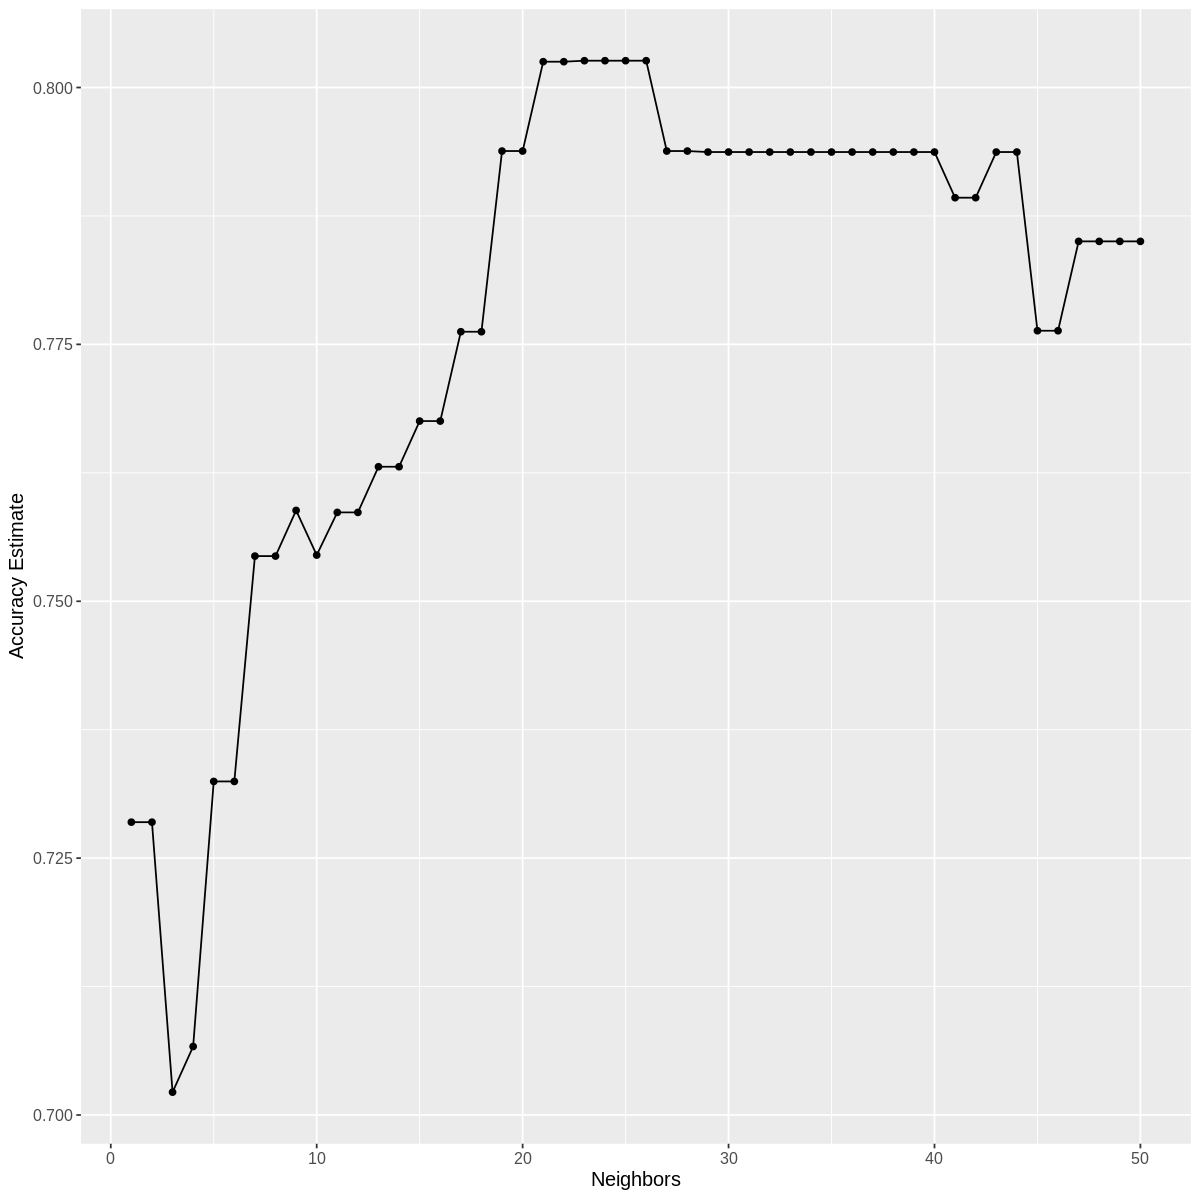

In [40]:
accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut

In [41]:
accuracies_final_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,accuracy,binary,0.8026087,5,0.01386701,Model26


In [42]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_mut

knn_fit_mut <- workflow() %>% 
  add_recipe(heart_recipe_mut) %>% 
  add_model(knn_spec_mut) %>% 
  fit(data = heart_disease_train_mut)
knn_fit_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 26
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~26, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2324561
Best kernel: rectangular
Best k: 26

In [43]:
heart_prediction_mut <- predict(knn_fit_mut, heart_disease_test_mut) %>% 
                    bind_cols(heart_disease_test_mut)

heart_metrics_mut <- heart_prediction_mut %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut <- heart_prediction_mut %>% 
                 conf_mat(truth = num, estimate = .pred_class)

heart_prediction_mut
heart_metrics_mut
mnist_conf_mat_mut

.pred_class,cp,thalach,exang,slope,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,3,187,0,3,3.5,0
0,2,178,0,1,0.8,0
1,4,160,0,3,3.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,4,90,0,2,1.0,1
1,4,123,1,2,0.2,1
1,4,141,0,2,3.4,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 35  8
         1  6 26

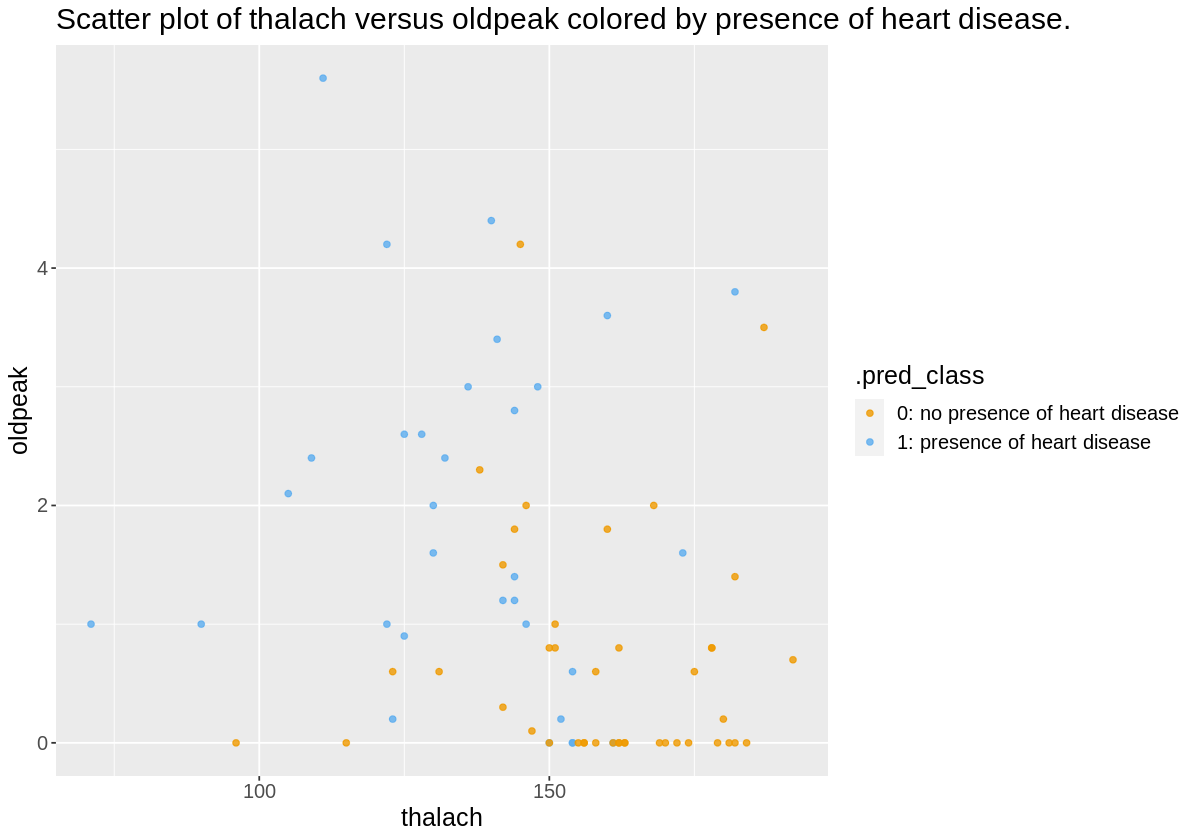

In [93]:
options(repr.plot.width = 10, repr.plot.height = 7)


two_predictors_ <- heart_prediction_mut %>%
  ggplot(aes(x = thalach, y = oldpeak, color = .pred_class)) +
  geom_point(alpha = 0.8) +
  labs(color = ".pred_class") +
  scale_color_manual(labels = c("0: no presence of heart disease", "1: presence of heart disease"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 15))+
  ggtitle("Scatter plot of thalach versus oldpeak colored by presence of heart disease.")

two_predictors_

*Figure 3: Scatter plot of thalach versus oldpeak colored by presence of heart disease.*

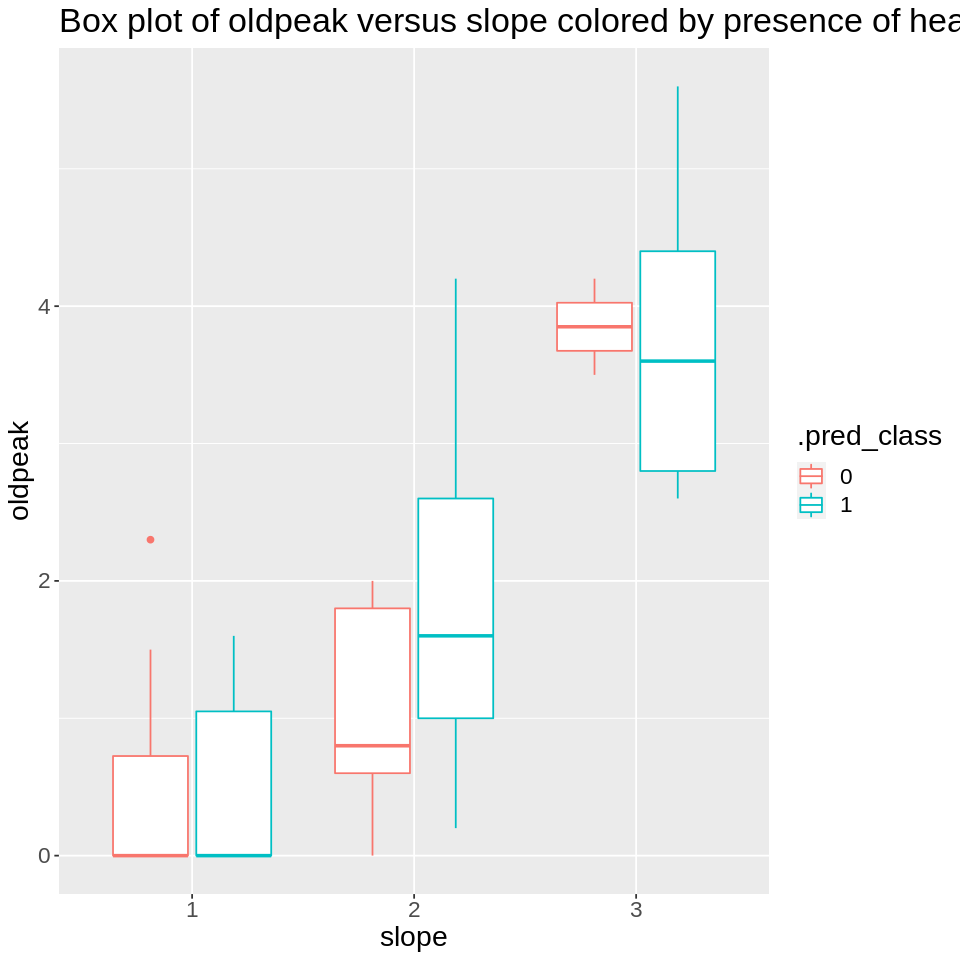

In [148]:
options(repr.plot.width = 8, repr.plot.height = 8)


two_predictors_111 <- heart_prediction_mut %>%
    mutate(slope = as.factor(slope)) %>% 
  ggplot(aes(x = slope, y = oldpeak, color = .pred_class)) +
  geom_boxplot() +
  theme(text = element_text(size = 17))+
  ggtitle("Box plot of oldpeak versus slope colored by presence of heart disease")

two_predictors_111

*Figure 4: Box plot of oldpeak versus slope colored by presence of heart disease.*

We infer that when an indivisual has the slope of the peak exercise ST segment Value at 2, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 2.<br>
We can also infer that when an indivisual has the slope of the peak exercise ST segment Value at 3, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 4.2 or below 3.5.<br>
Since the distribution of oldpeak given slope equals to 1 are about the same, we cannot predict one's presence of heart disease only from slope equals to 1.

In [183]:
options(repr.plot.width = 8, repr.plot.height = 8)

two_predictors_222 <- heart_prediction_mut %>%
    mutate(cp=as.factor(cp),exang=as.factor(exang))%>%
    group_by(cp,exang) %>%
    summarize(n= n())
# heart_prediction_mut_with_n <- heart_prediction_mut %>% 
#                         bind_cols(two_predictors_222)

    
# kkk <- two_predictors_222%>%
#   ggplot(aes(x = cp, y = n, color = .pred_class)) +
#   geom_point() +
#     labs(x="chest pain", y="exang", color = "prediction")
#   theme(text = element_text(size = 17))+
#   ggtitle("Box plot of oldpeak versus slope colored by presence of heart disease")

two_predictors_222



`summarise()` regrouping output by 'cp' (override with `.groups` argument)



cp,exang,n
<fct>,<fct>,<int>
1,0,3
1,1,2
2,0,11
⋮,⋮,⋮
3,1,3
4,0,19
4,1,21


### FINAL Visualization

In [44]:
# pred_vs_actual <- heart_prediction_mut %>% 
#                 select(.pred_class, cp, num) %>% 
                
                

ERROR: Error in parse(text = x, srcfile = src): <text>:5:0: unexpected end of input
3:                 
4:                 
  ^


In [ ]:
num_of_false_negative<-select(heart_prediction_mut, .pred_class == 1)

## 4 predictors
We picked a total of five predictors in the last classifier training case. We tried to improve the classifier by deducting the number of predictors.

In [120]:
heart_disease_data_4 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>% 
                    select(cp, thalach, exang, oldpeak, num) 
heart_disease_data_4   

#  mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg), 
#                             exang = as.factor(exang), slope = as.factor(slope), sex = as.factor(sex)) %>%

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,115,1,1.2,1
2,174,0,0.0,1
3,173,0,0.0,0


In [121]:
set.seed(1234)
heart_disease_split_mut_4 <- initial_split(heart_disease_data_4, prop = 0.75, strata = num)
heart_disease_train_mut_4 <- training(heart_disease_split_mut_4)
heart_disease_test_mut_4 <- testing(heart_disease_split_mut_4)

head(heart_disease_data_4, 10)

cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,163,1,0.6,0
4,147,0,1.4,1
4,155,1,3.1,1


In [122]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut_4

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [123]:
heart_recipe_mut_new_4 <- recipe(num ~ ., data = heart_disease_train_mut_4)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut_4 <- vfold_cv(heart_disease_train_mut_4, v = 5, strata = num)

In [124]:
k_lots_mut_4 <- tibble(neighbors = seq(from = 1, to = 80, by = 5))

knn_fit_mut_4 <- workflow() %>% 
            add_recipe(heart_recipe_mut_new_4) %>% 
            add_model(knn_spec_mut_4) %>% 
            tune_grid(resamples = heart_disease_vfold_mut_4, grid = k_lots_mut_4)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6978744,5,0.04185387,Model01
6,accuracy,binary,0.7586473,5,0.01249948,Model02
11,accuracy,binary,0.7543961,5,0.01736821,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,accuracy,binary,0.7717874,5,0.009548368,Model14
71,accuracy,binary,0.7761353,5,0.009291954,Model15
76,accuracy,binary,0.7672464,5,0.014402618,Model16


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
56,accuracy,binary,0.7849275,5,0.009147417,Model12


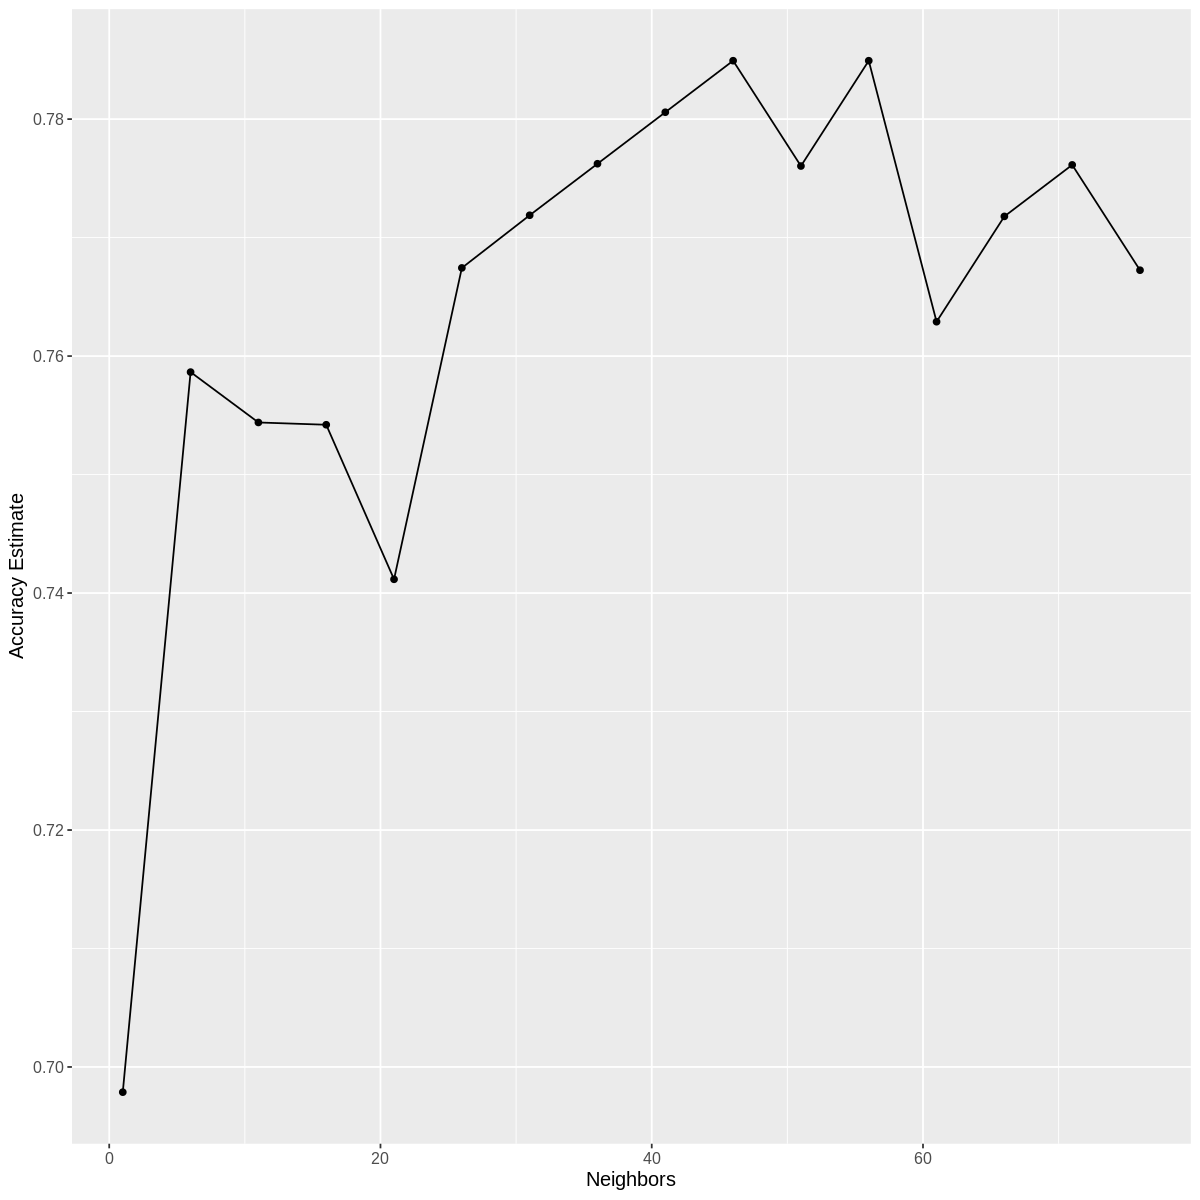

In [125]:
heart_disease_metrics_mut_4 <- knn_fit_mut_4 %>% 
                        collect_metrics()

accuracies_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") 
accuracies_mut_4
    
accuracy_vs_k_mut_4 <- ggplot(accuracies_mut_4, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut_4

accuracies_final_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut_4

In [140]:
final_k_for_4predictors <- accuracies_final_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)%>%select(neighbors)%>%pull()
final_k_for_4predictors

[1] 56

In [141]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = final_k_for_4predictors) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_mut_4

knn_fit_mut_4 <- workflow() %>% 
  add_recipe(heart_recipe_mut_new_4) %>% 
  add_model(knn_spec_mut_4) %>% 
  fit(data = heart_disease_train_mut_4)
knn_fit_mut_4

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = final_k_for_4predictors
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~final_k_for_4predictors,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2192982
Best kernel: rectangular
Best k: 56

In [142]:
heart_prediction_mut_4 <- predict(knn_fit_mut_4, heart_disease_test_mut_4) %>% 
                    bind_cols(heart_disease_test_mut_4)

heart_metrics_mut_4 <- heart_prediction_mut_4 %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut_4 <- heart_prediction_mut_4 %>% 
                 conf_mat(truth = num, estimate = .pred_class)

heart_prediction_mut_4
heart_metrics_mut_4
mnist_conf_mat_mut_4

.pred_class,cp,thalach,exang,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,3,187,0,3.5,0
0,2,178,0,0.8,0
1,4,160,0,3.6,1
⋮,⋮,⋮,⋮,⋮,⋮
1,4,90,0,1.0,1
1,4,123,1,0.2,1
1,4,141,0,3.4,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 36  9
         1  5 25

In [ ]:
source("cleanup.R")